In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
""" Semilla """
seed = 99


In [2]:

#data = pd.read_excel("c:/Users/dagom/Documents/docencia/DOCENCIA_FINAL_2023_PHYTON_ML_DANI/2_Introduccion_y_SVM/Chicago_Crimes_2012_to_2017.csv")
data = pd.read_csv("Chicago_Crimes_2012_to_2017.csv")
display(data)

Unnamed: 0                    Date Location Description  Arrest  Beat  \
0               1  05/03/2016 11:40:00 PM            APARTMENT    True  1022   
1               2  05/03/2016 09:40:00 PM            RESIDENCE   False   313   
2               3  05/03/2016 11:31:00 PM               STREET   False  1524   
3               4  05/03/2016 10:10:00 PM             SIDEWALK   False  1532   
4               5  05/03/2016 10:00:00 PM            RESIDENCE   False  1523   
...           ...                     ...                  ...     ...   ...   
12423       12424  05/18/2016 12:01:00 AM            APARTMENT   False  1131   
12424       12425  05/18/2016 04:00:00 AM               STREET   False  1914   
12425       12426  05/18/2016 02:50:00 AM   SMALL RETAIL STORE    True  2234   
12426       12427  05/18/2016 12:25:00 AM            APARTMENT   False  1412   
12427       12428  05/18/2016 04:36:00 AM            WAREHOUSE   False  1031   

       District   Latitude  Longitude  
0            10  41.864073 -87.706819  
1             3  41.782922 -87.604363  
2            15  41.894908 -87.758372  
3            15  41.885687 -87.749516  
4            15  41.886297 -87.761751  
...         ...        ...        ...  
12423        11  41.872460 -87.733547  
12424        19  41.965488 -87.648987  
12425        22  41.680602 -87.662443  
12426        14  41.931312 -87.714735  
12427        10  41.827126 -87.732881  

[12428 rows x 8 columns]

In [3]:

data = pd.DataFrame(data)
variables = data.columns.values

data = data.drop(columns=[variables[0]])  ## quitamos la primera variable que no dice nada

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}')
data.head()
data.info()


Número de filas: 12428, Número de columnas:7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12428 entries, 0 to 12427
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  12428 non-null  object 
 1   Location Description  12390 non-null  object 
 2   Arrest                12428 non-null  bool   
 3   Beat                  12428 non-null  int64  
 4   District              12428 non-null  int64  
 5   Latitude              11825 non-null  float64
 6   Longitude             11825 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 594.8+ KB


In [4]:


#################################
#### FE y depuración de datos ##
#################################

## Primero vemos cuantos missing tenemos en cada variable ##
data.isnull().sum()

data = data[~data["Latitude"].isnull()] ## eliminamos los datos mising
data.isnull().sum()

data = data[~data["Location Description"].isnull()] ## eliminamos los datos mising
data.isnull().sum()  ## sin missing ya (podriamos haberlos imputado pero en este caso no tiene sentido)

## si quiero quitarme todos de un solo paso
#data = data.dropna(axis=1)

###operaciones con fechas interesantes ## es clave para este problema

from datetime import datetime
import calendar


for n in data.index:
 aux= data["Date"][n]
 data["Date"][n]= datetime.strptime(aux, '%m/%d/%Y %I:%M:%S %p')

data.info()
data.head()
#datetime.strptime(date_string, format)

## de la variable tiempo sacamos 5 variables mas
# Primero me genero 5 variables nuevas

data["hour"]= data["Latitude"]
data["minute"]= data["Latitude"]
data["mes"]= data["Latitude"]
data["dia"]= data["Latitude"]
data["dayweek"]= data["Latitude"]


<class 'pandas.core.frame.DataFrame'>
Index: 11803 entries, 0 to 12427
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  11803 non-null  object 
 1   Location Description  11803 non-null  object 
 2   Arrest                11803 non-null  bool   
 3   Beat                  11803 non-null  int64  
 4   District              11803 non-null  int64  
 5   Latitude              11803 non-null  float64
 6   Longitude             11803 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 915.0+ KB


In [5]:

for n in data.index:
 aux= data["Date"][n]
 data["hour"][n] = aux.hour
 data["minute"][n] = aux.minute
 data["mes"][n] = aux.month
 data["dia"][n] = aux.day
 data["dayweek"][n] = calendar.day_name[aux.weekday()]


### ahora quitamos fecha

data = data.drop(columns=["Date"])

## separamos la variable target de las variables eplicativas si quisieramos hacer un modelo predictivo
variables = data.columns.values
X = data[[variables[2], variables[3], variables[4], variables[5], variables[6],variables[7],variables[8],variables[9],variables[10] ]]
y = data[variables[1]]


In [6]:
print(variables)

['Location Description' 'Arrest' 'Beat' 'District' 'Latitude' 'Longitude'
 'hour' 'minute' 'mes' 'dia' 'dayweek']


In [7]:
####

X.info()
X.describe()
y.value_counts()
############ ANALISIS DESCRIPTIVO CONTRA TARGET (IGUAL HAY QUE SEGUIR TRANSFORMANDO)
tabla_target=pd.DataFrame(data[variables[1]].value_counts())
table_location=pd.DataFrame(data["Location Description"].value_counts())
table_dayweek=pd.DataFrame(data["dayweek"].value_counts())
table_dia=pd.DataFrame(data["dia"].value_counts())
table_hour=pd.DataFrame(data["hour"].value_counts())
table_beat=pd.DataFrame(data["Beat"].value_counts())

#############
data.info()
## bidimensional entre todas contra target algunas cosas se pueden observar ya.....
sns.set_theme(style="ticks")
sns.pairplot(data, hue="Arrest")


Output hidden; open in https://colab.research.google.com to view.

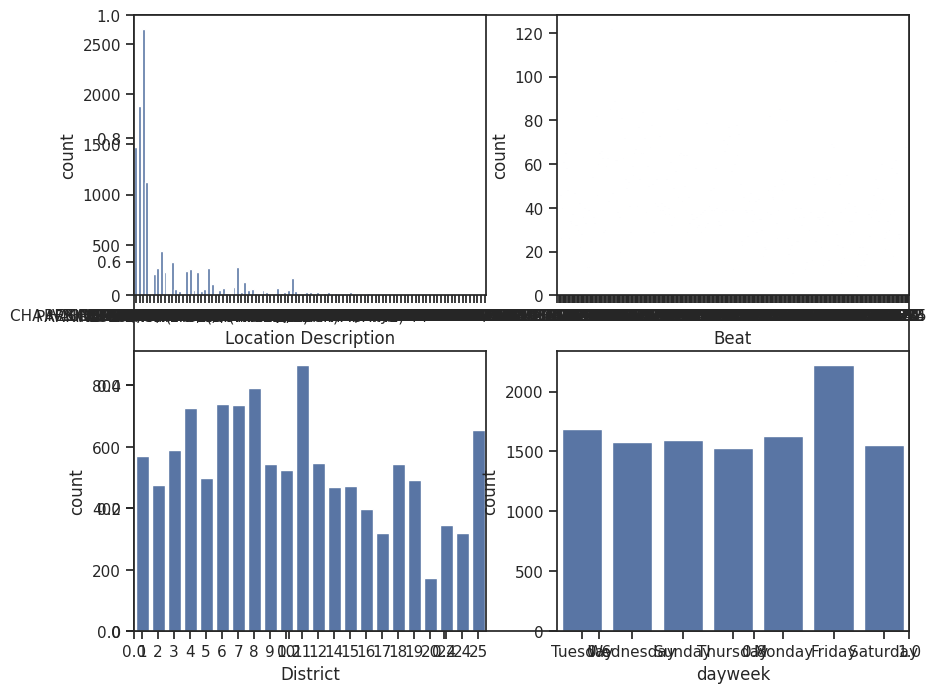

In [8]:
## se ven cosas pero vamos a diferencias categoricas, continuas y binarias en tres grupos para ver mejor....

col_cat = data[['Location Description', 'Beat', 'District', 'dayweek']]
col_num = data[['Latitude', 'Longitude', 'hour', 'minute', 'mes', 'dia']]
col_bin = data[['Arrest']]


###

#### visualizacion unidimensional categoricas
count=1
plt.subplots(figsize=(10, 8))
for i in col_cat.columns:
    plt.subplot(2,2,count)
    sns.countplot(x=col_cat[i], data = data, dodge = False)
    count+=1

plt.show()


In [ ]:
from scipy.stats import chi2_contingency
# Supongamos que 'target' es tu variable objetivo y 'categorical_var' es una variable categórica
# Crea una tabla de contingencia

for i in col_cat.columns:
    x=col_cat[i]
    contingency_table = pd.crosstab(y, x)
  # Realiza la prueba de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Imprime los resultados
    print('i=' , i)
    print(f"Chi-cuadrado: {chi2}")
    print(f"Valor p: {p}")

i= Location Description
Chi-cuadrado: 969.0354497657363
Valor p: 2.6164987811183185e-144
i= Beat
Chi-cuadrado: 851.7964492550561
Valor p: 9.443082305268268e-61
i= District
Chi-cuadrado: 366.6303170247927
Valor p: 7.182274742213958e-65
i= dayweek
Chi-cuadrado: 37.38901935754375
Valor p: 1.4786186988886748e-06


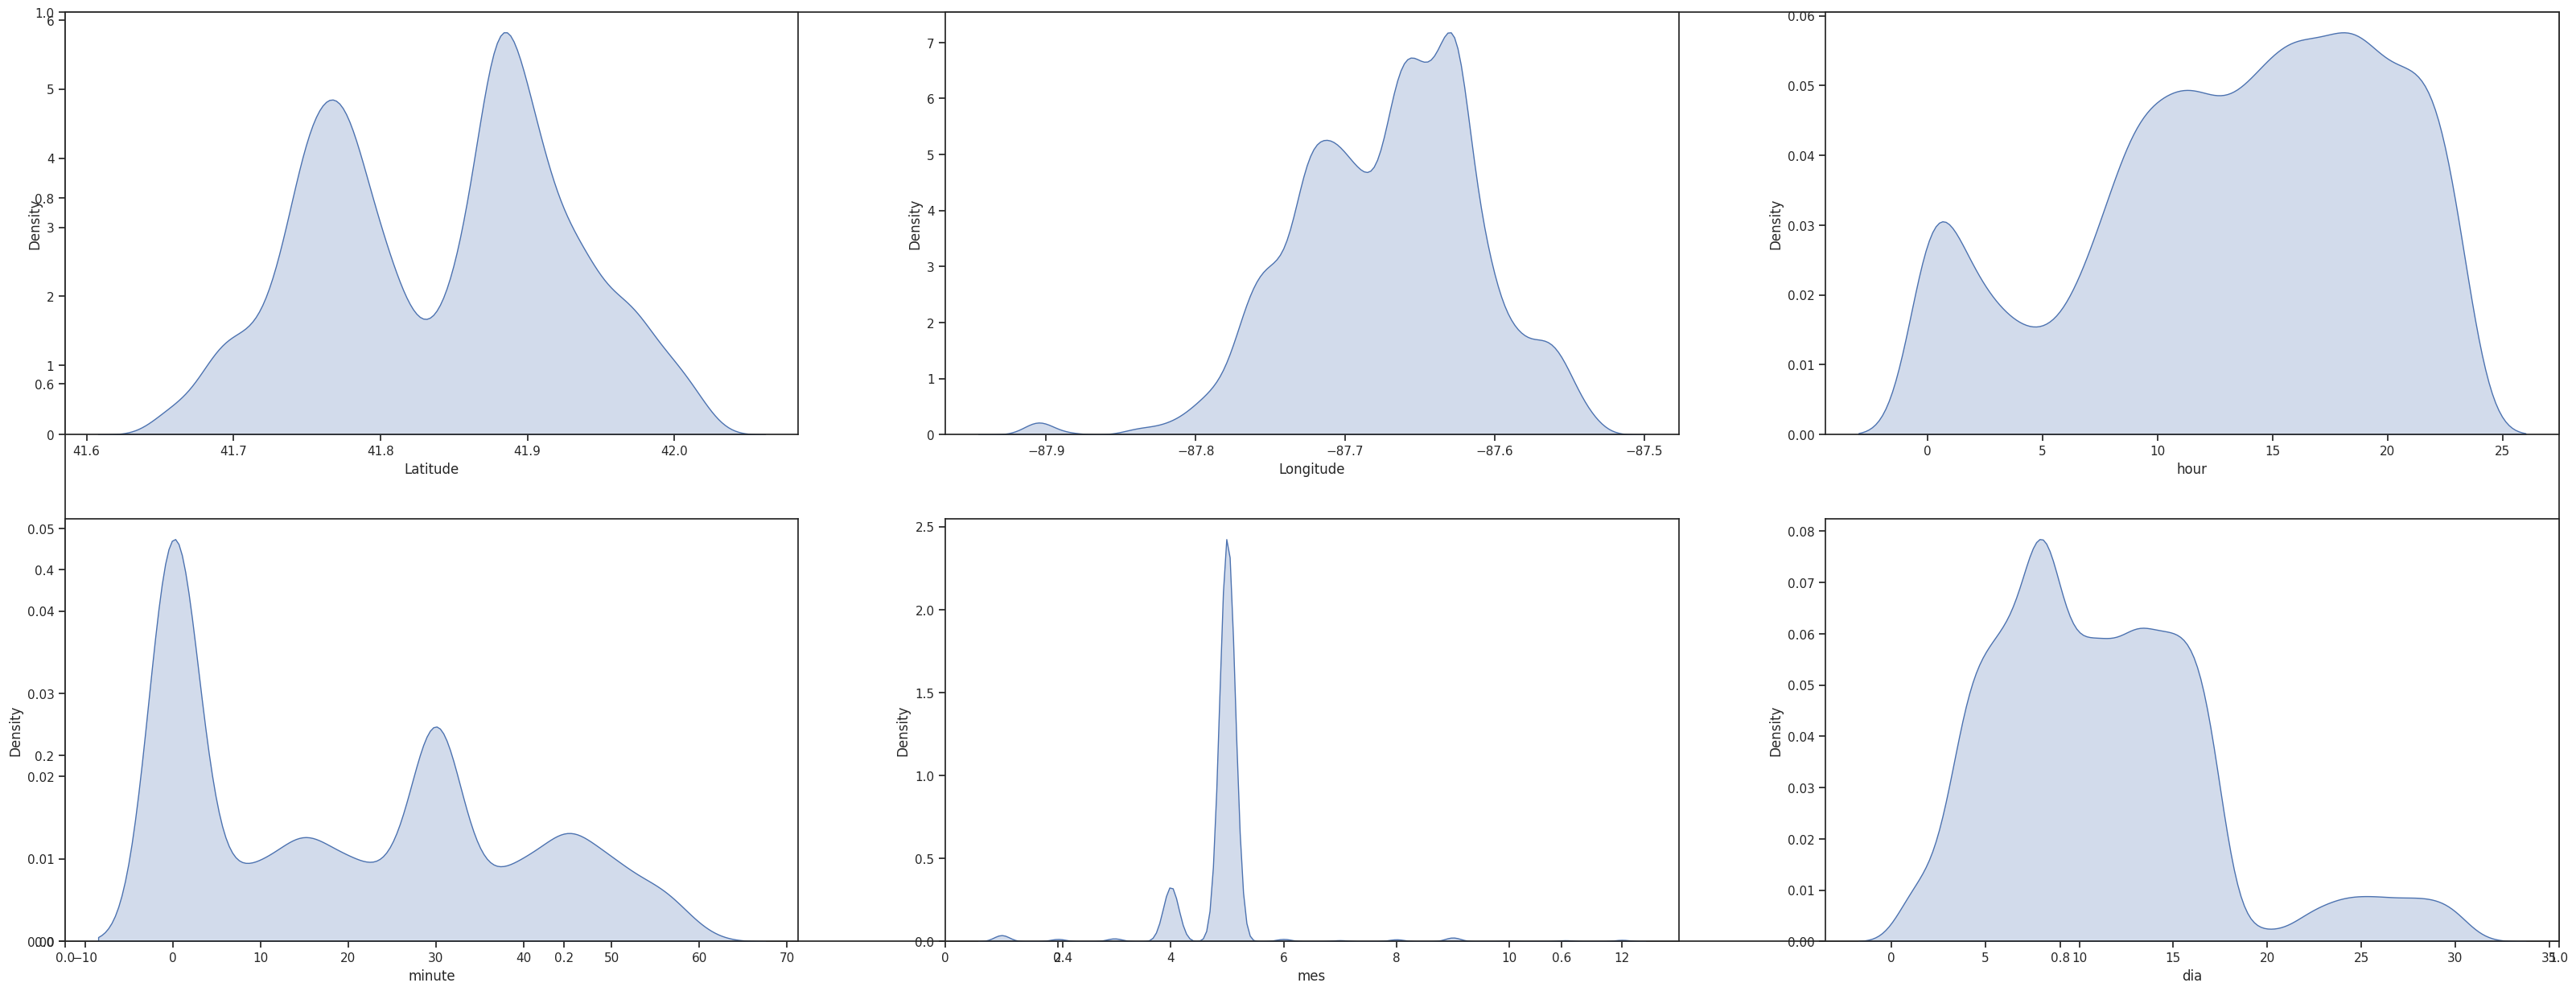

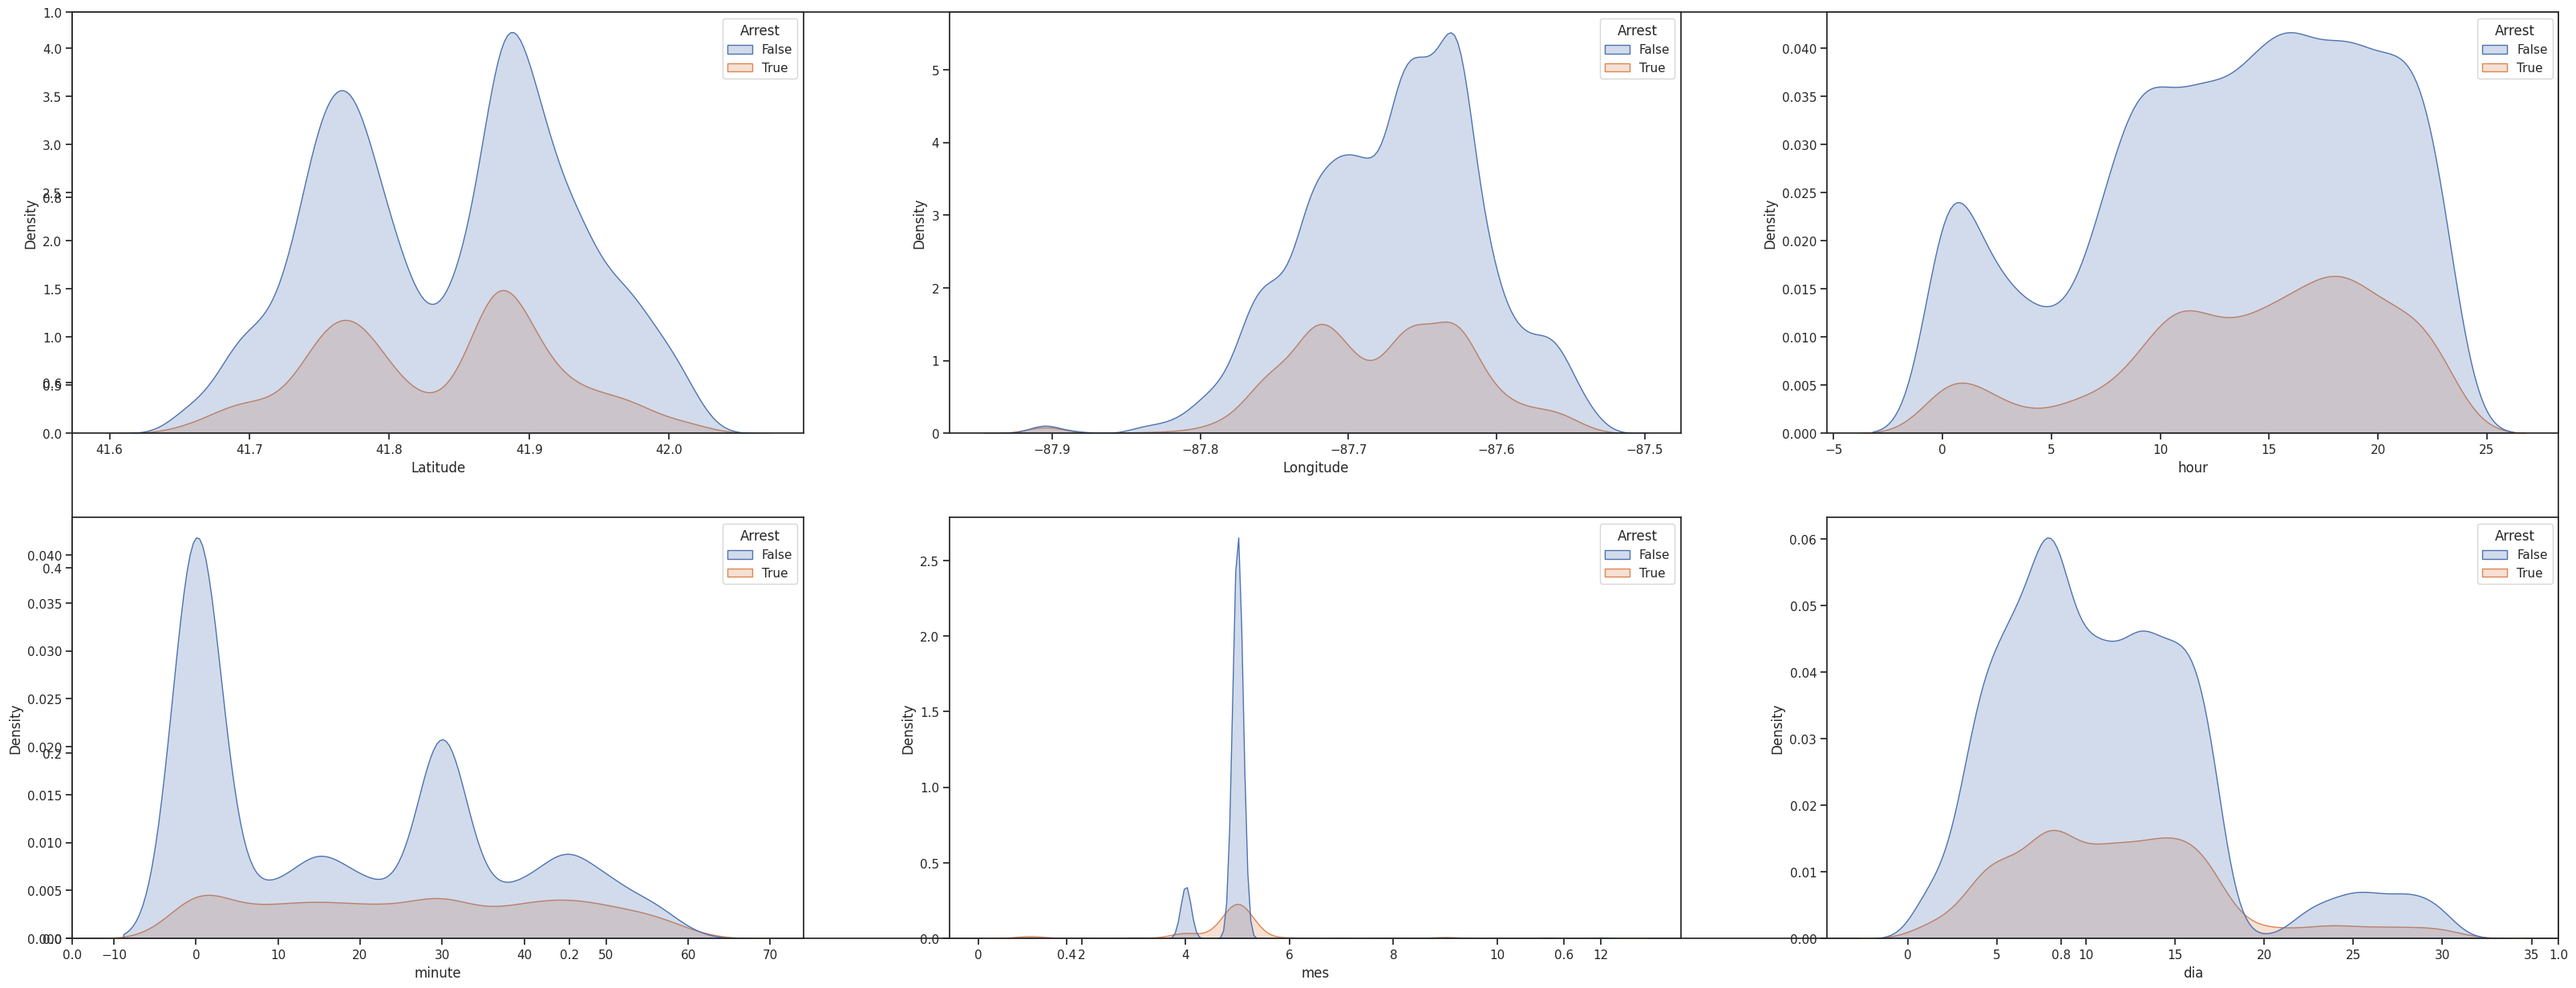

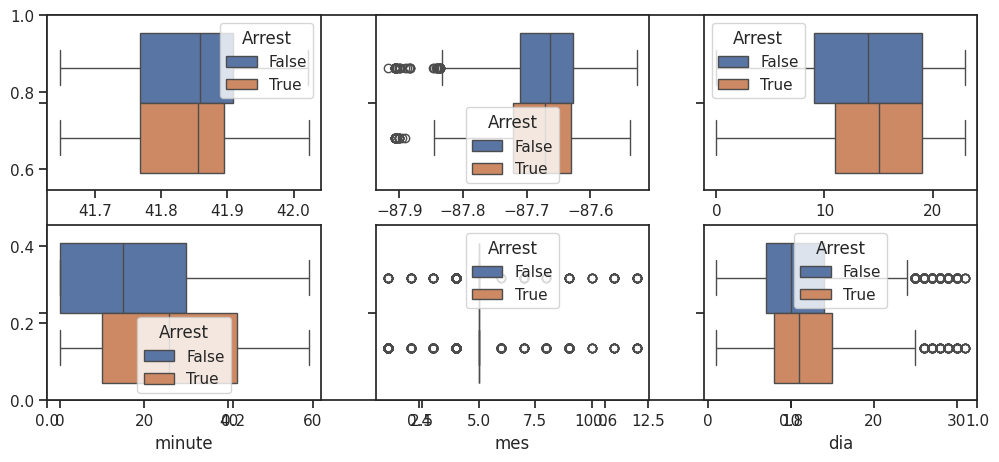

In [ ]:
## de los resultados que acabamos de ver tenemos dos variables categoricas
# que deben ser agrupadas o modificadas... porque tienen muchisimas categorias
## beat debe tener un tratamiento continuo ser eliminado o agrupado por un experto ...

count=1
plt.subplots(figsize=(40, 15))
for i in col_num.columns:
    plt.subplot(2,3,count)
    sns.kdeplot(x=col_num[i], data=data,  shade = True)
    count+=1

plt.show()

#### visualizacion bidimensional de las continuas frente al target
count=1
plt.subplots(figsize=(40, 15))
for i in col_num.columns:
    plt.subplot(2,3,count)
    sns.kdeplot(x=col_num[i], data=data, hue=data['Arrest'], shade = True)
    count+=1

plt.show()

## box plot
count=1
plt.subplots(figsize=(12, 5))
for i in col_num.columns:
    plt.subplot(2,3,count)
    sns.boxplot(x=col_num[i], data=data, hue=data['Arrest'])
    count+=1

plt.show()


In [ ]:
## no se hace analisis de outliers ##
############## visualizacion realizada ####
### Finalmente se generan dummies para las variables no continuas
## se puede estudiar reducir el numero de categorias para la variable Localizacion
print(table_location)
data= data.rename({'Location Description': 'Location'}, axis=1)
data['Location'] = data.Location.apply(lambda x: x if x in ['STREET','RESIDENCE','APARTMENT','SIDEWALK', 'PARKING LOT/GARAGE(NON.RESID.)'] else 'Otros')

table_location=pd.DataFrame(data["Location"].value_counts())
print(table_location)


# Creamos dummies solo para la red, en el resto sea realizará en el pipeline
data_dummies = pd.get_dummies(data,columns=['Location', 'dayweek'], drop_first= True)
data_dummies.head()

###################
## separamos la variable target de las variables eplicativas
variables = data_dummies.columns.values
X = data_dummies.drop('Arrest', axis=1)
y = data_dummies["Arrest"]


                                                count
Location Description                                 
STREET                                           2653
RESIDENCE                                        1886
APARTMENT                                        1478
SIDEWALK                                         1124
OTHER                                             442
...                                               ...
FACTORY/MANUFACTURING BUILDING                      1
AIRPORT TERMINAL LOWER LEVEL - SECURE AREA          1
FEDERAL BUILDING                                    1
CREDIT UNION                                        1
AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA      1

[97 rows x 1 columns]
                                count
Location                             
Otros                            4333
STREET                           2653
RESIDENCE                        1886
APARTMENT                        1478
SIDEWALK                         1124
PARKING L

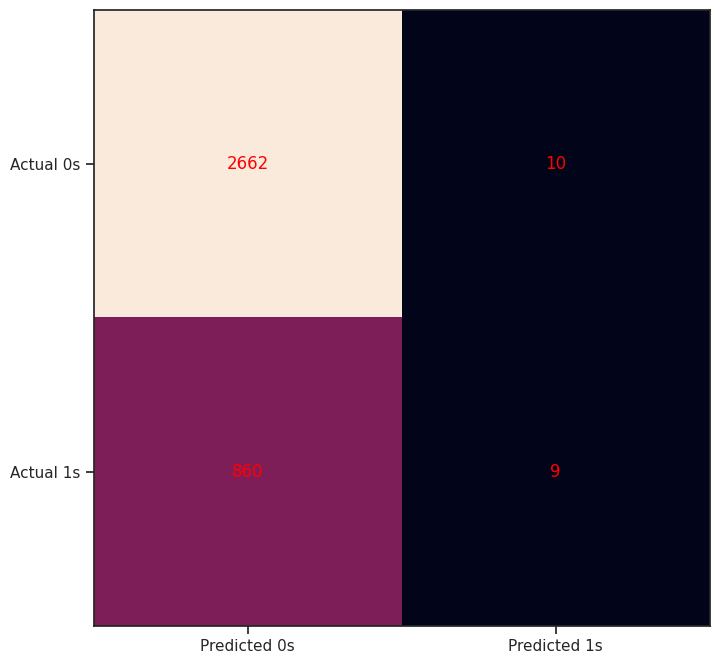

              precision    recall  f1-score   support

       False       0.80      0.95      0.87      2672
        True       0.62      0.26      0.36       869

    accuracy                           0.78      3541
   macro avg       0.71      0.60      0.61      3541
weighted avg       0.75      0.78      0.74      3541

[0.77 0.76 0.72 0.73 0.76]


In [ ]:
#########################################################
################## UNA SIMPLE REGRESIÓN LOGISTICA !!!!!!
#########################################################
# PASO 1. Dividimos train y test al 30 & 70

[X_train, X_test,y_train,y_test] = train_test_split(X,y,test_size=0.3)


#### PASO 2 SELECCION DE VARIABLES (ME LO VOY A SALTAR POR AHORA)

model = ExtraTreesClassifier()
model.fit(X_train, y_train)
model.feature_importances_

Importancia_tree=pd.DataFrame(zip(model.feature_importances_, X_train.columns), columns=['importance', 'feature'])\
    .sort_values('importance', ascending=False).head()


## PASO 3 DECIDIMOS EL MODELO (AQUI SIN TUNEAR NI BUSQUEDA PARAMETRICA NI NADA...)

lr = LogisticRegression()
lr.fit(X_train,y_train)

lr.classes_
lr.intercept_
lr.coef_
lr.predict_proba(X_test)
lr.predict(X_test)
lr.score(X_test, y_test)
lr.score(X_train, y_train)
confusion_matrix(y_test, lr.predict(X_test))

confusion_matrix(y_train, lr.predict(X_train))

cm = confusion_matrix(y_test, lr.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


print(classification_report(y_test, model.predict(X_test)))

## Paso 4 con validacion cruzada
from sklearn.model_selection import cross_val_score
model=lr
results = cross_val_score(estimator=model, X=X, y=y, cv=5)
print(results)



In [9]:


import folium
from folium.plugins import HeatMap

# Supongamos que tienes un DataFrame llamado 'df' con columnas 'latitud' y 'longitud'
# Asegúrate de tener instaladas las bibliotecas necesarias con: pip install folium pandas


# Crear un mapa centrado en las coordenadas iniciales
df=data
df.columns

mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)

# Convertir las coordenadas a una lista de listas
coordenadas = df[['Latitude', 'Longitude']].values.tolist()

# Agregar un mapa de calor
HeatMap(coordenadas).add_to(mapa)

# Guardar el mapa como un archivo HTML o mostrarlo en el cuaderno (dependiendo de tu entorno)
mapa.save('mapa_calor.html')  # Guarda el mapa como un archivo HTML
mapa


#########################
import folium
from folium.plugins import MarkerCluster, HeatMap

# Crear un mapa centrado en las coordenadas iniciales
df = data  # Asumo que ya tienes el DataFrame 'data' con las columnas 'Latitude', 'Longitude' y 'arrest'
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)

# Convertir las coordenadas y la variable 'arrest' a una lista de listas
datos_mapa = df[['Latitude', 'Longitude', 'Arrest']].values.tolist()

# Inicializar dos listas para almacenar las coordenadas de arrestos y no arrestos
coordenadas_arresto = []
coordenadas_no_arresto = []

for dato in datos_mapa:

    if dato[2] == True:

        coordenadas_arresto.append([dato[0], dato[1]])
    else:
        coordenadas_no_arresto.append([dato[0], dato[1]])

# Create a map for arrests
mapa_arresto = folium.Map(location=[0, 0], zoom_start=2)
arrest_cluster = MarkerCluster(name='Arresto', overlay=True, control=True, icon_create_function=None)

for coord in coordenadas_arresto:
    folium.Marker(location=coord, popup='Arresto', icon=folium.Icon(color='red')).add_to(arrest_cluster)

arrest_cluster.add_to(mapa_arresto)
HeatMap(coordenadas_arresto).add_to(mapa_arresto)

# Save the map for arrests
mapa_arresto.save('mapa_arresto.html')

# Create a map for no arrests
mapa_no_arresto = folium.Map(location=[0, 0], zoom_start=2)
no_arrest_cluster = MarkerCluster(name='No Arresto', overlay=True, control=True, icon_create_function=None)

for coord in coordenadas_no_arresto:
    folium.Marker(location=coord, popup='No Arresto', icon=folium.Icon(color='green')).add_to(no_arrest_cluster)

no_arrest_cluster.add_to(mapa_no_arresto)
HeatMap(coordenadas_no_arresto).add_to(mapa_no_arresto)

# Save the map for no arrests
mapa_no_arresto.save('mapa_no_arresto.html')